In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt
from torch import nn
import torch.nn.functional as F

from pycox.datasets import metabric
from pycox.models import CoxTime
from pycox.models.cox_time import MLPVanillaCoxTime
from pycox.evaluation import EvalSurv

from tqdm.notebook import tqdm

In [2]:
np.random.seed(1234)
_ = torch.manual_seed(123)

### Network Definition

In [156]:
# difficulty 分情况 w=0/1
class DiffNet(nn.Module):
    def __init__(self, feature_num, user_num, length, leveldiff_dim=0, challenge_dim=1, win_dim=2, 
                 diff_level=5,device="cpu", use_pretrain=False,
                fix_params=False, params=[],Min_Max=[]):
        super().__init__()
        beta = torch.randn((feature_num-3+2*diff_level, length))
        self.beta = nn.Parameter(beta)
        self.min_max = Min_Max
        if use_pretrain:
            alpha = torch.tensor(params[0]).unsqueeze(1) # alpha, user_num*1
            gamma = torch.tensor(params[1]).unsqueeze(1) # gamma, user_num*1     
            if fix_params:
                self.alpha = alpha
                self.gamma = gamma
                if device != "cpu":
                    self.alpha = self.alpha.cuda()
                    self.gamma = self.gamma.cuda()
            else:
                self.alpha = nn.Parameter(alpha,requires_grad=True)
                self.gamma = nn.Parameter(gamma,requires_grad=True)
                
        else:
            alpha = torch.rand((user_num,1))
            gamma = torch.randn((user_num,1))
            self.alpha = nn.Parameter(alpha)
            self.gamma = nn.Parameter(gamma)
        
        self.leveldiff_dim = leveldiff_dim
        self.challenge_dim = challenge_dim
        self.win_dim = win_dim
        self.diff_level = diff_level
        
        self.feature_num = feature_num
        self.user_num = user_num
        self.length = length
        self.device = device
    
    def forward(self, x_input, uid, t):
        # x_input: batch_size * feature_num * length
        # uid: batch_size * user_num
        
        u_alpha = torch.mm(uid, self.alpha.abs()).sum(dim=1) # u_alpha: batch_size*1
        u_gamma = torch.mm(uid, self.gamma).sum(dim=1).unsqueeze(1).repeat(1,self.length) # u_gamma: batch_size*length
        
        x_diff = (x_input[:,self.challenge_dim,:]-torch.mul(x_input[:,self.leveldiff_dim,:],u_alpha.unsqueeze(1))-u_gamma) # x_diff: batch_size*length
        
        level_diff = self.calculate_diff(x_diff, x_input[:,self.win_dim,:]) # batch_size * (diff_level*2) * length
        
        feature_idx = [i for i in range(feature_num) if 
                       i not in [self.leveldiff_dim,self.challenge_dim,self.win_dim]]
        x_input_diff = torch.cat((x_input[:,feature_idx,:],level_diff),dim=1) # batch_size*feature*length
        
        y = self.time_mul(x_input_diff,t)  # y: batch_size * 1
        return y # y: batch_size *1
    
    def time_mul(self, x_input, t):
        # x_input: batch_size * feature * length
        # t: batch_size * 1
        x_beta = (x_input*self.beta).sum(dim=1) # batch_size*length
        y = torch.gather(x_beta,dim=1,index=t.long()-1)#.unsqueeze(1)
        
        return y
    
    def predict(self, x_input, uid, t):
        return self.forward(x_input, uid, t)
    
    def one_hot(self, label):
        batch_size = label.shape[0]
        length = label.shape[1]
        label = label.resize_(batch_size, 1, length)
        if self.device=='cpu':
            m_zeros = torch.zeros(batch_size,  2*self.diff_level+1, length)
        else:
            m_zeros = torch.zeros(batch_size,  2*self.diff_level+1, length).cuda()
        onehot = m_zeros.scatter_(1, label, 1)[:,:-1]  # (dim,index,value)
        
        return onehot  # Tensor -> Numpy
    
    def calculate_diff(self, x, win):
        # x: batch_size*length
        # win: batch_size*length
        if len(self.min_max):
            Min,Max = self.min_max
        else:
            Min, Max = x.min(), x.max()
        #Min,Max = -2,2
        
        x_rescale = (x-Min+win*(Max-Min))/(Max-Min)*self.diff_level
        x_level = self.one_hot(x_rescale.floor().long()) # x_level: batch_size * diff_level * length
        
        return x_level  #batch_size* diff_level * length

### Dataset Construction

In [4]:
# load data
original_data = pd.read_csv("../data/Data_process/Cox_feature_interaction_part_last.csv")
original_data["win"] = original_data["last_win"].shift(-1)
original_data.fillna(0,inplace=True)

In [5]:
# select part of the dataset
print("original data size: ",original_data.shape)
all_data = original_data.loc[original_data.user_id<=1000]
print("select 1000 users, size: ",all_data.shape)

original data size:  (2244582, 22)
select 1000 users, size:  (1108991, 22)


In [6]:
# observe the session_length
print("Distribution of session length:")
pd.cut(all_data.groupby(["user_id","session_id"]).session_length.max(),bins=5).value_counts(normalize=True)

Distribution of session length:


(4.514, 102.2]    0.981982
(102.2, 199.4]    0.016410
(199.4, 296.6]    0.001368
(296.6, 393.8]    0.000222
(393.8, 491.0]    0.000018
Name: session_length, dtype: float64

In [7]:
# set max length of session (more, censored)
max_length = 160

In [8]:
# length clamp
all_data = all_data.loc[all_data.session_depth<max_length]
all_data["event"] = all_data["session_length"].apply(lambda x: x<=max_length)
all_data["cut_length"] = all_data["session_length"].apply(lambda x: min(x,max_length))

In [9]:
# select features, user list
feature_name = ["game_weekday","hour","session_id","day_session","last_item","last_win","last_duration","last_energy",
                "session_depth","avg_item","avg_duration","avg_passrate",
                "last_oneday","last_3day","last_oneweek","last_one","global_retrytime","retry_time","win"]
                #"global_passrate","pass_rate"]
feature_dict = dict(zip(feature_name,range(len(feature_name))))
features = all_data.loc[:,feature_name]
uid_list = all_data.loc[:,"user_id"].to_numpy()

In [11]:
# 根据session划分数据集：每个用户随机sample 1/10为test set，1/10为validation set
import random

def generate_dict(name):
    dict_t = {}
    cnt = 0
    for uid in session_dict_list[name]:
        dict_t[uid] = {}
        for sid in session_dict_list[name][uid]:
            dict_t[uid][sid] = cnt
            cnt += 1
    return dict_t

random.seed(2020)
# session_list: pandas, 每一行表示一个用户，记录三个数据集对应的session id
session_list = all_data.groupby(["user_id"]).session_id.apply(lambda x:(sorted(list(set(x))))).reset_index().rename(columns={"session_id":"session_list"})
session_list["session_num"] = session_list["session_list"].apply(lambda x: len(x))
session_list["session_list"].apply(lambda x:random.shuffle(x))
session_list["train_list"] = session_list.apply(lambda x: x["session_list"][:int(x["session_num"]*0.8)],axis=1)
session_list["val_list"] = session_list.apply(lambda x: x["session_list"][int(x["session_num"]*0.8):int(x["session_num"]*0.9)],axis=1)
session_list["test_list"] = session_list.apply(lambda x: x["session_list"][int(x["session_num"]*0.9):],axis=1)
# session_dict_list: dict，第一层key表示数据集，第二层key为user id，value为session id的list
session_ulist = session_list.user_id.tolist()
session_dict_list = {}
for col in session_list.columns:
    if "list" in col and "session" not in col:
        session_dict_list[col] = dict(zip(session_ulist,session_list[col].tolist()))

# 对三个数据集下的session重新从0开始编号（方便生成session为基础的矩阵）
dict_train = generate_dict("train_list")
dict_val = generate_dict("val_list")
dict_test = generate_dict("test_list")

# all_data中每一行，划分到train、val、test，记录对应的idx和session re-id
train_idx,test_idx,val_idx = [],[],[]
train_sidx, test_sidx, val_sidx = [],[],[]
for i,(uid, sid) in enumerate(zip(all_data.user_id.tolist(),all_data.session_id.tolist())):
    if sid in session_dict_list["train_list"][uid]:
        train_idx.append(i)
        train_sidx.append(dict_train[uid][sid])
    elif sid in session_dict_list["val_list"][uid]:
        val_idx.append(i)
        val_sidx.append(dict_val[uid][sid])
    elif sid in session_dict_list["test_list"][uid]:
        test_idx.append(i)
        test_sidx.append(dict_test[uid][sid])
    else:
        print(uid,sid)
        break

In [12]:
# 拟合Difficulty曲线
def plot_linear(x,y, a,b, uid=0,savefig=False,filename=""):
    # scatter original data, plot the linear ax+b
    plt.figure(figsize=(10,5))
    ax = plt.subplot()
    ax.scatter(x,y,s=2)
    ax.plot(x,a*x+b,color='r')
    ax.set_xlabel("level difficulty (global retry time)",fontsize=16)
    ax.set_ylabel("user's retry time",fontsize=16)
    ax.set_title("User %d"%(uid),fontsize=18)
    if savefig:
        plt.savefig("figures/"+filename)
    plt.show()

# get retry data from training set
train_df = all_data.iloc[train_idx, :]
retry_data = train_df.loc[train_df.win==1].groupby(["user_id","level_id"]).head(1)
retry_data = retry_data.loc[:,["user_id","global_retrytime","retry_time"]]
retry_dedup = retry_data.groupby(["user_id","global_retrytime"]).agg({"retry_time":"mean"}).reset_index()

# fit the curve
Neighbor = 5
uidlist, alist, blist, selist,lenlist, selist_all = [],[],[],[],[],[]
for uid in tqdm(set(retry_dedup.user_id.tolist())):
    uidlist.append(uid)
    x = retry_dedup.loc[retry_dedup.user_id==uid].global_retrytime.to_numpy()
    y = retry_dedup.loc[retry_dedup.user_id==uid].retry_time.to_numpy()
    y_cum = y.cumsum()
    y_smooth = np.array([(y_cum[min(i+Neighbor,len(y)-1)]-y_cum[max(i-Neighbor,0)])/(2*Neighbor+1) for i in range(len(y))])

    A = np.vstack([x,np.ones(len(x))]).T
    results = np.linalg.lstsq(A,y_smooth, rcond=None)
    alist.append(results[0][0])
    blist.append(results[0][1])
    selist.append(results[1][0]/len(x))
    selist_all.append(results[1][0])
    lenlist.append(len(x))
fit_results = pd.DataFrame(np.array([uidlist, alist, blist, selist,lenlist,selist_all]).T,
                           columns=["user_id","a","b","s_e","length","s_e_all"])

In [13]:
top_fit = fit_results.sort_values(by="s_e").head(20)
worst_fit = fit_results.sort_values(by="s_e").tail(20)

In [14]:
# for row in top_fit.iterrows():
#     print("user id: %d, a: %.2f, b:%.2f, length: %d"%(row[1].user_id,row[1].a,row[1].b,row[1].length))
#     uid = row[1].user_id
#     x = retry_dedup.loc[retry_dedup.user_id==uid].global_retrytime.to_numpy()
#     y = retry_dedup.loc[retry_dedup.user_id==uid].retry_time.to_numpy()
#     y_cum = y.cumsum()
#     y_smooth = np.array([(y_cum[min(i+Neighbor,len(y)-1)]-y_cum[max(i-Neighbor,0)])/(2*Neighbor+1) for i in range(len(y))])

#     plot_linear(x,y_smooth,row[1].a,row[1].b,uid)

In [22]:
y_depth = all_data.session_depth.to_numpy()
train_dict = dict(zip(train_idx,train_sidx))
val_dict = dict(zip(val_idx,val_sidx))
test_dict = dict(zip((test_idx),test_sidx))
uid_nodup = list(set(uid_list)) # uid 去重
uid_dict = dict(zip(uid_nodup,range(len(set(uid_list)))))

In [27]:
# 得到user对应a、b拟合结果
user_alpha = dict(zip(fit_results.user_id.tolist(),fit_results.a.tolist()))
user_gamma = dict(zip(fit_results.user_id.tolist(),fit_results.b.tolist()))
alpha_list = [user_alpha.get(uid,0) for uid in uid_nodup]
gamma_list = [user_gamma.get(uid,0) for uid in uid_nodup]

In [31]:
# standardize
cols_standardize = ["session_id","day_session","last_item","last_win","last_duration","session_depth","avg_item","avg_duration","last_oneday","last_3day","last_oneweek","last_one"]
cols_leave = ["avg_passrate","win","global_retrytime","retry_time"]
cols_minmax = ["game_weekday","hour","last_energy"]#,"global_retrytime","retry_time"]

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]
minmax = [([col],MinMaxScaler()) for col in cols_minmax]

x_mapper = DataFrameMapper(standardize + leave+minmax)

features_np = features.to_numpy()
features_np[train_idx,:] = x_mapper.fit_transform(features.iloc[train_idx,:]).astype('float32')
features_np[val_idx,:] = x_mapper.transform(features.iloc[val_idx,:]).astype('float32')
features_np[test_idx,:] = x_mapper.transform(features.iloc[test_idx,:]).astype('float32')

In [33]:
events = all_data.event.tolist()

In [34]:
# 三个数据集的sample
x_itrain = np.zeros((len(set(train_dict.values())),len(feature_name),max_length))
x_ival = np.zeros((len(set(val_dict.values())),len(feature_name),max_length))
x_itest = np.zeros((len(set(test_dict.values())),len(feature_name),max_length))
# 三个数据集的每个样本对应的user id
x_utrain = torch.zeros((len(set(train_dict.values())),len(uid_dict)))
x_uval = torch.zeros((len(set(val_dict.values())),len(uid_dict)))
x_utest = torch.zeros((len(set(test_dict.values())),len(uid_dict)))
# 三个数据集的label
y_train_length, y_train_event = np.zeros((len(set(train_dict.values())))), np.zeros((len(set(train_dict.values()))))
y_test_length, y_test_event = np.zeros((len(set(test_dict.values())))), np.zeros((len(set(test_dict.values()))))
y_val_length, y_val_event = np.zeros((len(set(val_dict.values())))), np.zeros((len(set(val_dict.values()))))
for i in tqdm(range(len(y_depth))):
    if i in train_dict:
        x_itrain[train_dict[i],:,y_depth[i]] = features_np[i,:]
        x_utrain[train_dict[i],uid_dict[uid_list[i]]] = 1
        y_train_length[train_dict[i]] = max(y_train_length[train_dict[i]],y_depth[i]+1)
        y_train_event[train_dict[i]] = events[i]
        
    elif i in val_dict:
        x_ival[val_dict[i],:,y_depth[i]] = features_np[i,:]
        x_uval[val_dict[i],uid_dict[uid_list[i]]] = 1
        y_val_length[val_dict[i]] = max(y_val_length[val_dict[i]],y_depth[i]+1)
        y_val_event[val_dict[i]] = events[i]
        
    elif i in test_dict:
        x_itest[test_dict[i],:,y_depth[i]] = features_np[i,:]
        x_utest[test_dict[i],uid_dict[uid_list[i]]] = 1
        y_test_length[test_dict[i]] = max(y_test_length[test_dict[i]],y_depth[i]+1)
        y_test_event[test_dict[i]] = events[i]
        
    else:
        print(i)
        break

In [38]:
def generate_data(x,uid,y_l,y_c):
    return (torch.FloatTensor(x), uid), (y_l,y_c)

x_train,y_train = generate_data(x_itrain,x_utrain,y_train_length,y_train_event)
x_val,y_val = generate_data(x_ival,x_uval,y_val_length,y_val_event)
x_test,y_test = generate_data(x_itest,x_utest,y_test_length,y_test_event)

In [39]:
durations_test, events_test = y_test

In [40]:
y_train = (torch.tensor(y_train[0]),torch.tensor(y_train[1]))
y_val = (torch.tensor(y_val[0]),torch.tensor(y_val[1]))
val_data = tt.tuplefy(x_val, y_val)

###  Model definition

In [57]:
feature_num,length = x_itrain.shape[1], x_itrain.shape[2]
user_num = len(set(uid_list))
device="cuda"
#device="cpu"
diff_level=5 # difficulty to n levels
print("feature number: %d, length: %d, user number: %d, difficulty level: %d"%(feature_num,length,user_num,diff_level))
print("device: %s"%(device))

feature number: 19, length: 160, user number: 944, difficulty level: 5
device: cuda


In [42]:
# 不fix params
# np.random.seed(1234)
# _ = torch.manual_seed(123)
# diffnet = DiffNet(feature_num, user_num, length,leveldiff_dim = feature_dict["global_retrytime"],
#                   challenge_dim=feature_dict["retry_time"],win_dim=feature_dict["win"],diff_level=diff_level,device=device)
# model = CoxTime(diffnet, tt.optim.Adam,device=device)#labtrans=labtrans)

In [157]:
# fix params
np.random.seed(1234)
_ = torch.manual_seed(123)

diffnet = DiffNet(feature_num, user_num, length,leveldiff_dim = feature_dict["global_retrytime"],
                  challenge_dim=feature_dict["retry_time"],win_dim=feature_dict["win"],
                  diff_level=diff_level,device=device,
                 use_pretrain = True, fix_params=True, params=[alpha_list,gamma_list])
model = CoxTime(diffnet, tt.optim.Adam,device=device)#labtrans=labtrans)

### Model Training

In [66]:
# test
if device=="cuda":
    uid = x_train[1][:1000].cuda()
    x_input = x_train[0][:1000].cuda()
    y_t = y_train[0][:1000].unsqueeze(1).cuda()
else:
    uid = x_train[1][:1000]
    x_input = x_train[0][:1000]
    y_t = y_train[0][:1000].unsqueeze(1)
y = model.net.forward(x_input,uid,y_t)

best lr:  0.15556761439304817


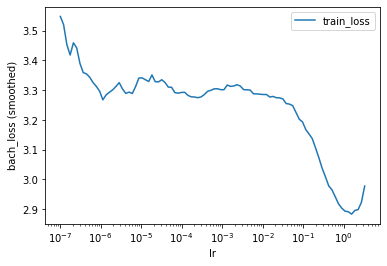

In [68]:
# lr find
batch_size = 512
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=5)
_ = lrfinder.plot()
print("best lr: ",lrfinder.get_best_lr())

In [418]:
%%time
# for batch_size in [512,1024,2048,4096]:
#     for lr in [0.2,0.1,0.05,0.02,0.01,0.001]:
#for lr in [0.01]:
#lr = 0.01
lr = 0.05
batch_size=2048
print("learning rate: ",lr)
print("bach_size: ",batch_size)
np.random.seed(1234)
_ = torch.manual_seed(123)

# diffnet = DiffNet(feature_num, user_num, length,leveldiff_dim = feature_dict["global_retrytime"],
#               challenge_dim=feature_dict["retry_time"],win_dim=feature_dict["win"],diff_level=diff_level,device=device)
diffnet = DiffNet(feature_num, user_num, length,leveldiff_dim = feature_dict["global_retrytime"],
                  challenge_dim=feature_dict["retry_time"],win_dim=feature_dict["win"],
                  diff_level=diff_level,device=device,
                 use_pretrain = True,fix_params=True, params=[alpha_list,gamma_list])

model = CoxTime(diffnet, tt.optim.Adam,device=device)#labtrans=labtrans)

epochs=256
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

model.optimizer.set_lr(lr)
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
            val_data=val_data)

baseline_hazards = model.compute_baseline_hazards()
surv = model.predict_surv(x_test)
surv_df = pd.DataFrame(surv.numpy().T)
ev = EvalSurv(surv_df, durations_test, events_test, censor_surv='km')
c_index = ev.concordance_td("antolini")
print("C INDEX: ",c_index)

learning rate:  0.05
bach_size:  2048
0:	[7s / 7s],		train_loss: 2.3046,	val_loss: 1.4530
1:	[5s / 12s],		train_loss: 1.1412,	val_loss: 0.9229
2:	[5s / 18s],		train_loss: 0.8198,	val_loss: 0.7735
3:	[5s / 23s],		train_loss: 0.6979,	val_loss: 0.7045
4:	[3s / 26s],		train_loss: 0.6573,	val_loss: 0.6851
5:	[2s / 29s],		train_loss: 0.6428,	val_loss: 0.6730
6:	[2s / 31s],		train_loss: 0.6349,	val_loss: 0.6818
7:	[2s / 34s],		train_loss: 0.6332,	val_loss: 0.6514
8:	[2s / 37s],		train_loss: 0.6255,	val_loss: 0.6591
9:	[2s / 39s],		train_loss: 0.6239,	val_loss: 0.6618
10:	[2s / 42s],		train_loss: 0.6295,	val_loss: 0.6670
11:	[2s / 44s],		train_loss: 0.6253,	val_loss: 0.6684
12:	[2s / 46s],		train_loss: 0.6256,	val_loss: 0.6700
13:	[2s / 49s],		train_loss: 0.6262,	val_loss: 0.6685
14:	[2s / 52s],		train_loss: 0.6257,	val_loss: 0.6762
15:	[2s / 54s],		train_loss: 0.6262,	val_loss: 0.6784
16:	[2s / 57s],		train_loss: 0.6255,	val_loss: 0.6748
17:	[2s / 59s],		train_loss: 0.6199,	val_loss: 0.6697
C

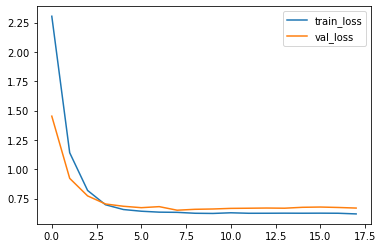

In [262]:
_ = log.plot()

In [149]:
# 不预训练
log.to_pandas().val_loss.min()

0.6514222025871277

In [119]:
# 预训练
log.to_pandas().val_loss.min()

0.6514129042625427

----
## Prediction

In [150]:
model.net.alpha.min(),model.net.alpha.max()

(tensor(0.0005, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.9979, device='cuda:0', grad_fn=<MaxBackward1>))

In [155]:
model.net.alpha.min()

tensor(-0.3873, device='cuda:0')

In [148]:
model.net.alpha.min(),model.net.alpha.max()

(tensor(-0.3873, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(3.8038, device='cuda:0', grad_fn=<MaxBackward1>))

In [150]:
min(alpha_list),max(alpha_list)

(-0.38732702211942405, 3.8037966162659815)

In [151]:
model.net.gamma.min(),model.net.gamma.max()

(tensor(-2.8600, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(3.2976, device='cuda:0', grad_fn=<MaxBackward1>))

In [152]:
baseline_hazards.shape

(156,)

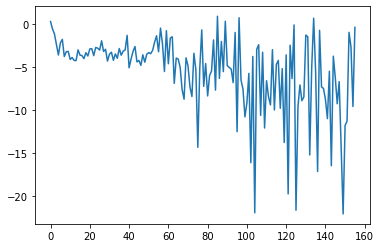

In [153]:
# 不预训练
plt.plot(np.arange(baseline_hazards.shape[0]),np.log(baseline_hazards.values))

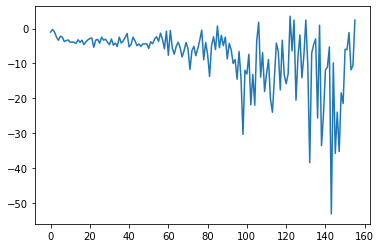

In [122]:
# 做预训练
plt.plot(np.arange(baseline_hazards.shape[0]),np.log(baseline_hazards.values))

In [123]:
surv = model.predict_surv(x_test)
surv_train = model.predict_surv((x_train[0],x_train[1]))

In [423]:
events_test

array([1., 1., 1., ..., 1., 1., 1.])

In [434]:
durations_test.min()

5.0

In [446]:
(S_j.numpy()>S_i.numpy()).sum()

1736

In [448]:
len(S_j[0])

2780

In [449]:
All_cnt = 0
larger_cnt = 0
for i in range(surv.shape[0]):
    if events_test[i]==0:
        continue
    S_i = surv[i,int(durations_test[i]-5)].numpy()
    j_list = np.where(durations_test>durations_test[i])
    S_j = surv[j_list,int(durations_test[i]-5)].numpy()
    larger_cnt += (S_j>S_i).sum()
    All_cnt += len(S_j[0])

In [451]:
larger_cnt,All_cnt,larger_cnt/All_cnt

(10970185, 15898250, 0.6900246882518516)

In [437]:
larger_cnt/All_cnt

tensor(1884)

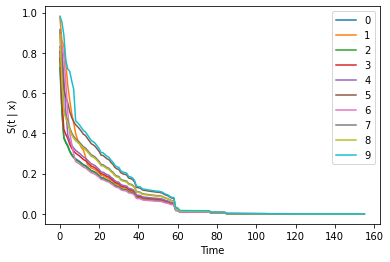

In [419]:
pd.DataFrame(surv.numpy().T).iloc[:,0:10].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [125]:
durations_test[0:10]

array([ 5., 19.,  6.,  6.,  9.,  7., 13.,  6.,  7., 13.])

----
## Evaluation

In [155]:
# 不做预训练
surv_df = pd.DataFrame(surv.numpy().T)
ev = EvalSurv(surv_df, durations_test, events_test, censor_surv='km')
print("C-index for test set: ",ev.concordance_td("antolini")) # 0.742
surv_df_train = pd.DataFrame(surv_train.numpy().T)
ev_train = EvalSurv(surv_df_train,y_train[0].numpy(),y_train[1].numpy())#,censor_surv='km')
print("C-index for training set: ",ev_train.concordance_td("antolini")) # 0.738

0.7421107983583098

In [126]:
# 做预训练
surv_df = pd.DataFrame(surv.numpy().T)
ev = EvalSurv(surv_df, durations_test, events_test, censor_surv='km')
print("C-index for test set: ",ev.concordance_td("antolini")) # 0.742
surv_df_train = pd.DataFrame(surv_train.numpy().T)
ev_train = EvalSurv(surv_df_train,y_train[0].numpy(),y_train[1].numpy())#,censor_surv='km')
print("C-index for training set: ",ev_train.concordance_td("antolini")) # 0.738

C-index for test set:  0.692150960011322
C-index for training set:  0.6747422299319056


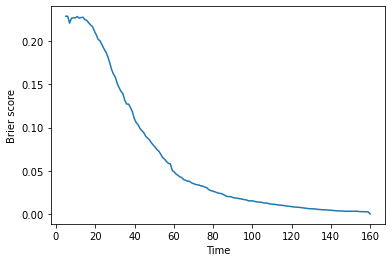

In [263]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 161)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

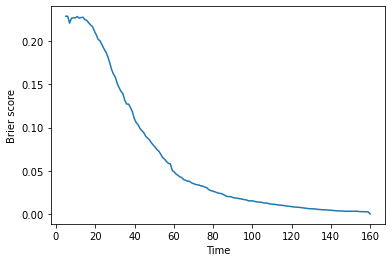

In [127]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 161)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

In [161]:
# IBS 不做预训练
ev.brier_score(time_grid).mean()

0.059494172609931666

In [264]:
# IBS 做预训练
ev.brier_score(time_grid).mean()

0.06271028200051462

-----
## Survival to churn prediction

In [280]:
alpha = abs(model.net.alpha.cpu().detach().numpy())
beta = (model.net.beta.cpu().detach().numpy())
gamma = model.net.gamma.cpu().detach().numpy()
h0 = baseline_hazards.values.tolist()

In [130]:
all_features = features_np
all_uid = all_data["user_id"].to_numpy()

In [376]:
m = []
cnt = 0
select_featuredim = [feature_dict[key] for key in feature_dict if key not in ["retry_time",
                                                                          "global_retrytime","win"]]
diff_list = []
for feature,uid in (zip(all_features,all_uid)):
    #print(feature,uid)
    if cnt%100000==0:
        print(cnt)
    cnt += 1
    diff = feature[feature_dict["retry_time"]]-alpha[uid_dict[uid]] \
            *feature[feature_dict["global_retrytime"]]- gamma[uid_dict[uid]]
    diff_list.append(diff)

Min, Max = min(diff_list),max(diff_list)
for feature,uid, diff in zip(all_features,all_uid,diff_list):
    if cnt%100000==0:
        print(cnt)
    cnt += 1
    win = feature[feature_dict["win"]]
    scale_diff = (diff-Min+win*(Max-Min))/(Max-Min)*diff_level
    
    t = int(feature[feature_dict["session_depth"]])
    beta_this = beta[:,t]
    if scale_diff == diff_level*2:
        beta_diff = 0
    else:
        beta_diff = beta[feature_num-3+int(scale_diff),t]
    m.append((beta_this[select_featuredim]*feature[select_featuredim]).sum()+beta_diff)

In [132]:
all_data["g_x"] = m
all_data["h_t"] = all_data.apply(lambda x: np.exp(x.g_x)*h0[max(x.session_depth-4,0)],axis=1)

In [133]:
# 对每条数据，计算H(t|x): 当前session到目前的h之和，计算S(t|x)= exp(-H(t|x))
uids, sids, hts = all_data.user_id.tolist(), all_data.session_id.tolist(), all_data.h_t.tolist()
depths = all_data.session_depth.tolist()
H_t = [hts[0]]
labels = []
for i in range(1,len(uids)):
    if uids[i] == uids[i-1] and sids[i]==sids[i-1] and depths[i]>=5:
        H_t.append(H_t[i-1] + hts[i])
        labels.append(False)
    else:
        H_t.append(hts[i])
        labels.append(True)
all_data["H_t"] = H_t
labels.append(True)
all_data["S_t"] = np.exp(-all_data["H_t"])

#标注true label（是否离开）
all_data["label"] = labels

In [378]:
surv.shape

torch.Size([5839, 156])

In [502]:
help(ax.scatter)

Help on method scatter in module matplotlib.axes._axes:

scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=<deprecated parameter>, edgecolors=None, *, plotnonfinite=False, data=None, **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    A scatter plot of *y* vs. *x* with varying marker size and/or color.
    
    Parameters
    ----------
    x, y : scalar or array-like, shape (n, )
        The data positions.
    
    s : scalar or array-like, shape (n, ), optional
        The marker size in points**2.
        Default is ``rcParams['lines.markersize'] ** 2``.
    
    c : array-like or list of colors or color, optional
        The marker colors. Possible values:
    
        - A scalar or sequence of n numbers to be mapped to colors using
          *cmap* and *norm*.
        - A 2-D array in which the rows are RGB or RGBA.
        - A sequence of colors of length n.
        - A single color format

/work/lijiayu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  # Remove the CWD from sys.path while we load stuff.


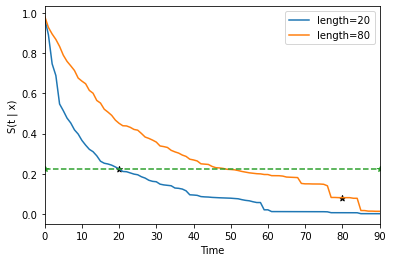

In [516]:
plt.figure()
ax = plt.subplot()
surv_np = surv.numpy().T
plt_idxs = [311,4835]
plts = []
for idx in plt_idxs:
    plts.append(ax.plot(surv_np[:,idx]))
    ax.scatter(x=durations_test[idx],y=surv_np[int(durations_test[idx]),idx],marker="*",c="black")    
labels = ["length=%d"%(durations_test[idx]) for idx in plt_idxs]
plt.legend(plts,labels=labels)
idx=311
ax.plot([0,90],[surv_np[int(durations_test[idx]),idx],surv_np[int(durations_test[idx]),idx]],"*--")
plt.xlim([0,90])
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [480]:
durations_test[[311,1258]]

array([20., 80.])

In [416]:
durations_test.argmin()

0

In [387]:
durations_test

array([ 5., 19.,  6., ...,  7., 11., 10.])

In [260]:
# 计算AUC、ACC
from sklearn.metrics import roc_auc_score

# 做预训练
# test
y_pred = all_data.iloc[test_idx,:].loc[(all_data.session_id!=0)&(all_data.session_depth>3)&(all_data.event==True)].h_t.to_numpy()
y_label = all_data.iloc[test_idx,:].loc[(all_data.session_id!=0)&(all_data.session_depth>3)&(all_data.event==True)].label.to_numpy()
print("test auc: ",roc_auc_score(y_label, y_pred))
# y_pred = all_data.iloc[train_idx,:].loc[(all_data.session_id!=0)&(all_data.session_depth>3)&(all_data.event==True)].S_t.tolist()
# y_label = all_data.iloc[train_idx,:].loc[(all_data.session_id!=0)&(all_data.session_depth>3)&(all_data.event==True)].label.tolist()
# print("train auc: ",roc_auc_score(y_label, y_pred))

test auc:  0.46427994390150407


-----

In [258]:
y_pred = all_data.iloc[test_idx,:].loc[(all_data.session_id!=0)&
                                       (all_data.session_depth>3)&(all_data.event==True)].h_t.to_numpy()
y_label = all_data.iloc[test_idx,:].loc[(all_data.session_id!=0)&
                                        (all_data.session_depth>3)&(all_data.event==True)].label.to_numpy()

In [248]:
# 不同阈值下的precision and recall
def get_pre_rec(y_pred, y_label, threshold=0.5):
    y_pred = y_pred>=threshold
    # recall
    recall = ((y_label.astype(int)+y_pred)==2).sum() / y_label.sum()
    # precision
    precision = ((y_label.astype(int)+y_pred)==2).sum() / y_pred.sum()
    
    print("Threshold: %.2f, precision: %.3f, recall: %.3f"%(threshold, precision, recall))

In [251]:
y_label.sum()/y_label.shape[0],(y_pred>=0.9).sum()/y_pred.shape[0]

(0.0656626575226017, 0.8354068304786849)

In [259]:
for threshold in np.arange(0,1,0.1):
    get_pre_rec(y_pred,y_label,threshold)

Threshold: 0.00, precision: 0.066, recall: 1.000
Threshold: 0.10, precision: 0.065, recall: 0.637
Threshold: 0.20, precision: 0.064, recall: 0.577
Threshold: 0.30, precision: 0.063, recall: 0.539
Threshold: 0.40, precision: 0.063, recall: 0.512
Threshold: 0.50, precision: 0.062, recall: 0.493
Threshold: 0.60, precision: 0.061, recall: 0.476
Threshold: 0.70, precision: 0.061, recall: 0.460
Threshold: 0.80, precision: 0.060, recall: 0.444
Threshold: 0.90, precision: 0.059, recall: 0.432


In [194]:
precision,recall

(0.743736493386212, 0.13015723148003946)

In [185]:
y_bpred

array([False, False, False, ...,  True,  True,  True])

In [187]:
np.array(y_label)

array([False, False, False, ..., False, False,  True])

In [178]:
from collections import Counter
Counter(y_label)

Counter({False: 616416, True: 42109})

## Parameters analysis

In [ ]:
# 对alpha进行分析：
# 1. 用户平均user_diff/global_diff，与alpha的关系 （散点图）
# 2. 取top50中的10个用户和bottom50中的10个用户，随机选择一个session，看随session长度变化，用户 diff/global diff 的差异
# 


Text(0, 0.5, 'user histogram')

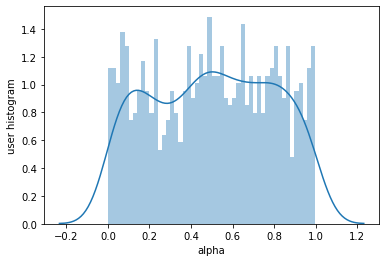

In [118]:
import seaborn as sns
# 不做预训练
plt.figure()
sns.distplot(alpha,bins=50)
plt.xlabel("alpha")
plt.ylabel("user histogram")

Text(0, 0.5, 'user histogram')

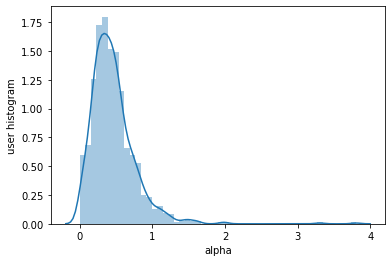

In [105]:
import seaborn as sns
# 做预训练
plt.figure()
sns.distplot(alpha,bins=50)
plt.xlabel("alpha")
plt.ylabel("user histogram")

In [265]:
Min,Max

(array([-4.8364477], dtype=float32), array([1.9090691], dtype=float32))

In [266]:
Scale_list = [Min]
Range = (Max-Min)/5
for i in range(5):
    Scale_list.append(Scale_list[-1]+Range)

In [518]:
lose_beta = beta[feature_num-3:feature_num-3+diff_level,:].T
win_beta = beta[feature_num-3+diff_level:feature_num-3+diff_level*2,:].T

[-0.481577   -0.3241369  -0.41173545 -0.12661764  0.721465  ]


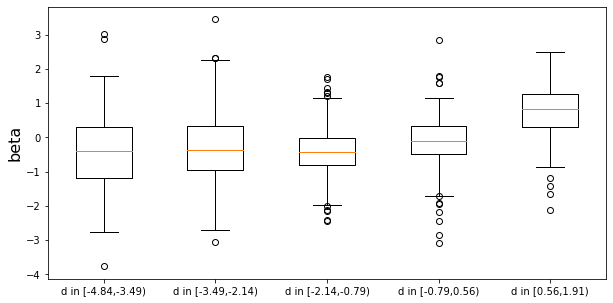

In [346]:
plt.figure(figsize=(10,5))
ax = plt.subplot()
ax.boxplot(lose_beta)
labels = ["d in [%.2f,%.2f)"%(Scale_list[i],Scale_list[i+1]) for i in range(5)]
ax.set_xticklabels(labels,fontsize=10)
ax.set_ylabel("beta",fontsize=16)
print(lose_beta.mean(axis=0))

[ 0.2729602  -0.31352028 -0.11535652 -0.16295913 -0.04371712]


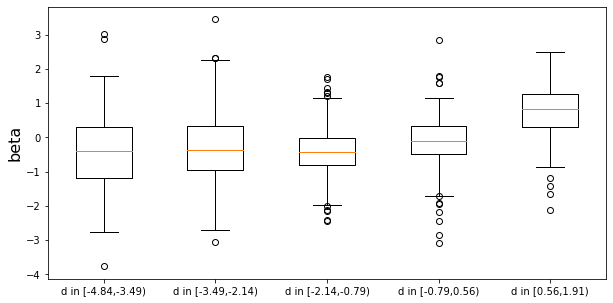

In [519]:
plt.figure(figsize=(10,5))
ax = plt.subplot()
ax.boxplot(lose_beta)
labels = ["d in [%.2f,%.2f)"%(Scale_list[i],Scale_list[i+1]) for i in range(5)]
ax.set_xticklabels(labels,fontsize=10)
ax.set_ylabel("beta",fontsize=16)
print(win_beta.mean(axis=0))

In [370]:
train_df.loc[train_df.win==0].session_depth

11          1
12          2
28         18
33         23
37         27
           ..
1108986     3
1108987     4
1108988     5
1108989     6
1108990     7
Name: session_depth, Length: 703660, dtype: int64

In [372]:
y_train[0]

tensor([ 9.,  9.,  6.,  ..., 20.,  8., 28.], dtype=torch.float64)

Text(0, 0.5, 'sample size')

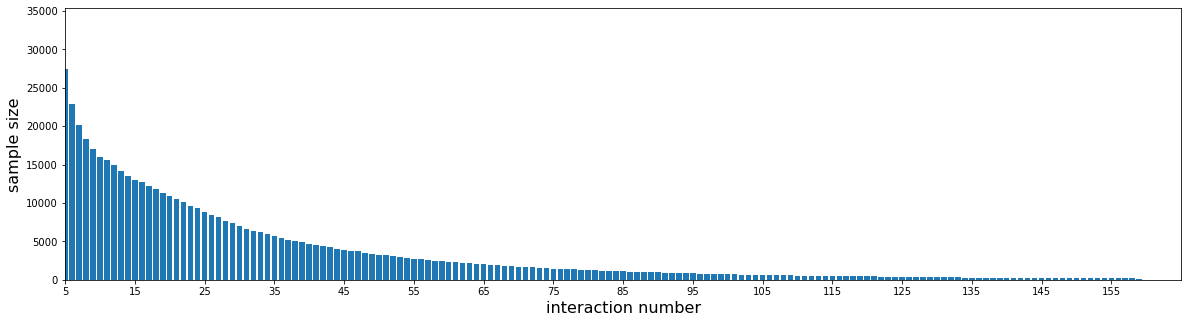

In [373]:
plt.figure(figsize=(20,5))
ax = plt.subplot()
# y_length_dist = Counter(y_train[0].numpy())
# y_length = np.array(sorted(y_length_dist.keys(),reverse=True))
# cum_counts = np.array([y_length_dist[k] for k in y_length]).cumsum()
y_length_dist = Counter(train_df.loc[train_df.win==0].session_depth)
y_length = np.array(sorted(y_length_dist.keys(),reverse=True))
cum_counts = np.array([y_length_dist[k] for k in y_length])
ax.bar(x=y_length, height=cum_counts)
ax.set_xlim([5,165])
ax.set_xticks(np.arange(5,165,10))
ax.set_xlabel("interaction number",fontsize=16)
ax.set_ylabel("sample size",fontsize=16)

Text(0, 0.5, 'sample size')

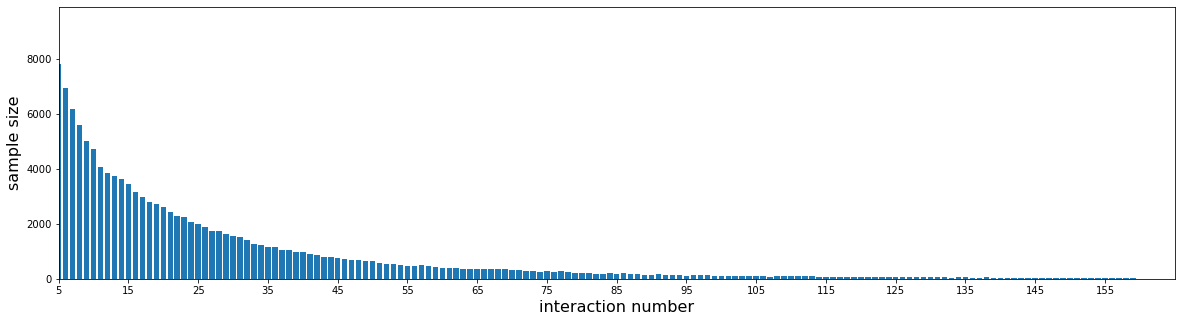

In [374]:
plt.figure(figsize=(20,5))
ax = plt.subplot()
# y_length_dist = Counter(y_train[0].numpy())
# y_length = np.array(sorted(y_length_dist.keys(),reverse=True))
# cum_counts = np.array([y_length_dist[k] for k in y_length]).cumsum()
y_length_dist = Counter(train_df.loc[train_df.win==1].session_depth)
y_length = np.array(sorted(y_length_dist.keys(),reverse=True))
cum_counts = np.array([y_length_dist[k] for k in y_length])
ax.bar(x=y_length, height=cum_counts)
ax.set_xlim([5,165])
ax.set_xticks(np.arange(5,165,10))
ax.set_xlabel("interaction number",fontsize=16)
ax.set_ylabel("sample size",fontsize=16)

In [359]:
np.arange(0,len(y_cum)-step,step)

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
       130, 135, 140, 145])

/work/lijiayu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


Text(0, 0.5, 'beta_diff')

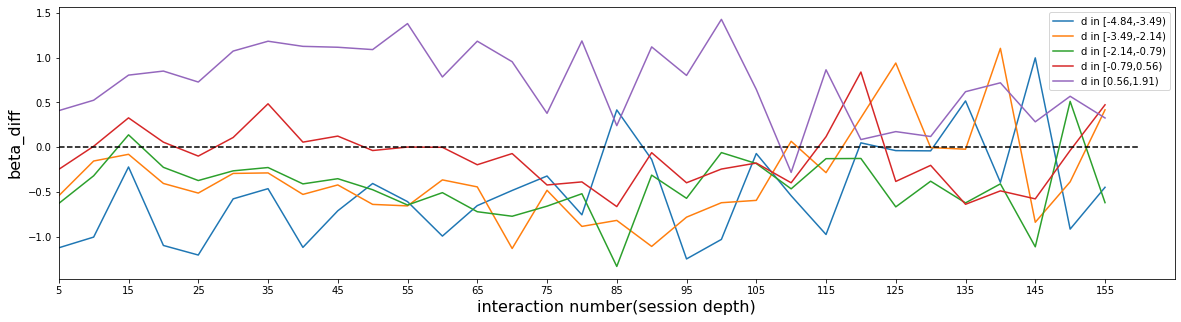

In [363]:
# 对beta进行分析：
# beta_diff 在不同时刻的变化plot: win=0
# fix alpha和gammma
plt.figure(figsize=(20,diff_level))
ax = plt.subplot()
plots = []
Neighbor = 5
step = 5
x = np.arange(5,160)
for i in range(0,diff_level):
    #plots.append(ax.plot(beta[feature_num-3+i,:100].cumsum()/np.arange(1,101)))
    y_cum = np.append(np.array([0]),lose_beta[5:,i].cumsum())
    y_smooth = np.array([(y_cum[min(i+Neighbor,len(y_cum)-1)]-
                          y_cum[max(i-Neighbor,0)])/(2*Neighbor+1) for i in range(len(y_cum))])
    y_range = np.array([(y_cum[i+step]-y_cum[i])/step for i in np.arange(0,len(y_cum)-step,step)])
    #plots.append(ax.plot(x,y_smooth))
    plots.append(ax.plot(x[np.arange(0,len(y_cum)-step,step)],y_range))
    
#labels = ["[0.6,1)","[-0.2,0.2)","(-1,-0.6]"]
labels = ["d in [%.2f,%.2f)"%(Scale_list[i],Scale_list[i+1]) for i in range(5)]
plt.legend(plots,labels=labels)
ax.plot([5,160],[0,0],"--k")
ax.set_xlim([5,165])
ax.set_xticks(np.arange(5,165,10))
ax.set_xlabel("interaction number(session depth)",fontsize=16)
ax.set_ylabel("beta_diff",fontsize=16)

/work/lijiayu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


Text(0, 0.5, 'beta_diff')

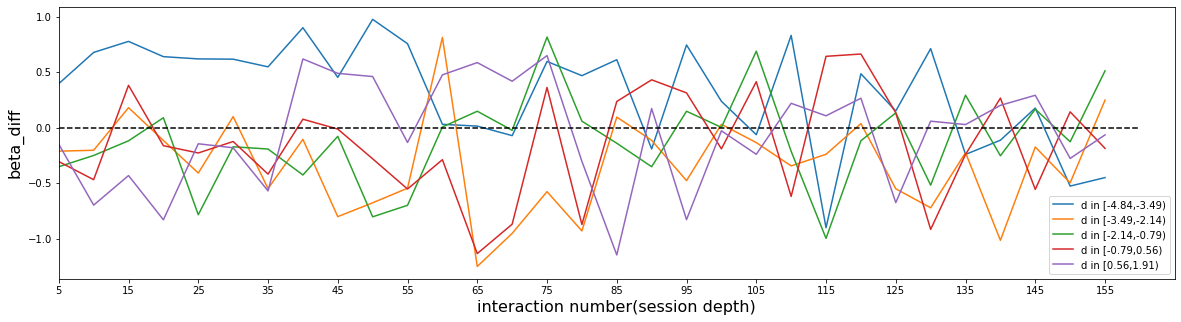

In [367]:
# 对beta进行分析：
# beta_diff 在不同时刻的变化plot: win=0
# fix alpha和gammma
plt.figure(figsize=(20,diff_level))
ax = plt.subplot()
plots = []
Neighbor = 5
step = 5
x = np.arange(5,160)
for i in range(0,diff_level):
    #plots.append(ax.plot(beta[feature_num-3+i,:100].cumsum()/np.arange(1,101)))
    y_cum = np.append(np.array([0]),win_beta[5:,i].cumsum())
    y_smooth = np.array([(y_cum[min(i+Neighbor,len(y_cum)-1)]-
                          y_cum[max(i-Neighbor,0)])/(2*Neighbor+1) for i in range(len(y_cum))])
    y_range = np.array([(y_cum[i+step]-y_cum[i])/step for i in np.arange(0,len(y_cum)-step,step)])
    #plots.append(ax.plot(x,y_smooth))
    plots.append(ax.plot(x[np.arange(0,len(y_cum)-step,step)],y_range))
    
#labels = ["[0.6,1)","[-0.2,0.2)","(-1,-0.6]"]
labels = ["d in [%.2f,%.2f)"%(Scale_list[i],Scale_list[i+1]) for i in range(5)]
plt.legend(plots,labels=labels)
ax.plot([5,160],[0,0],"--k")
ax.set_xlim([5,165])
ax.set_xticks(np.arange(5,165,10))
ax.set_xlabel("interaction number(session depth)",fontsize=16)
ax.set_ylabel("beta_diff",fontsize=16)

/work/lijiayu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  from ipykernel import kernelapp as app


[0.56631243, -0.17588133, -0.151759, -0.16454746, -0.07493815]

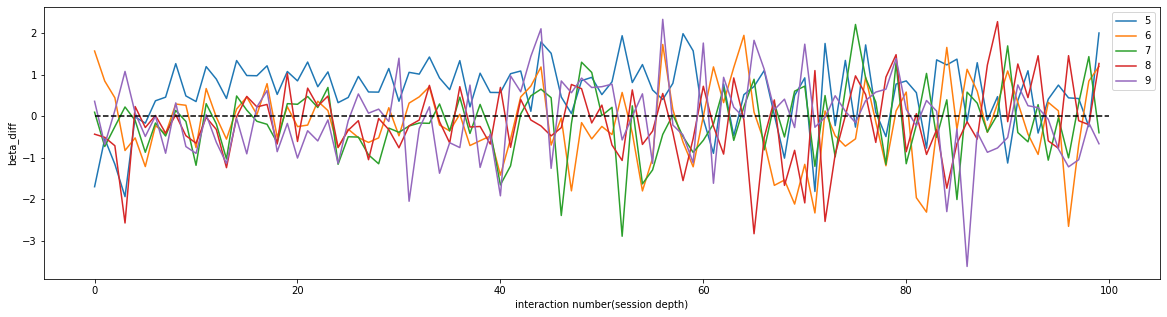

In [108]:
# 对beta进行分析：
# beta_diff 在不同时刻的变化plot: win=1
# fix alpha and gamma
plt.figure(figsize=(20,diff_level))
ax = plt.subplot()
plots = []
Mean = []
for i in range(0,diff_level):
    #plots.append(ax.plot(beta[feature_num-3+diff_level+i,:100].cumsum()/np.arange(1,101)))
    plots.append(ax.plot(beta[feature_num-3+diff_level+i,:100]))
    Mean.append(beta[feature_num-3+diff_level+i,:100].mean())

#labels = ["[0.6,1)","[-0.2,0.2)","(-1,-0.6]"]
labels = np.arange(diff_level,2*diff_level)
plt.legend(plots,labels=labels)
ax.plot([0,100],[0,0],"--k")
ax.set_xlabel("interaction number(session depth)")
ax.set_ylabel("beta_diff")
Mean

----

/work/lijiayu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  app.launch_new_instance()


[-0.20875883, -0.14382862, -0.024639804, -0.06502042, -0.03246824]

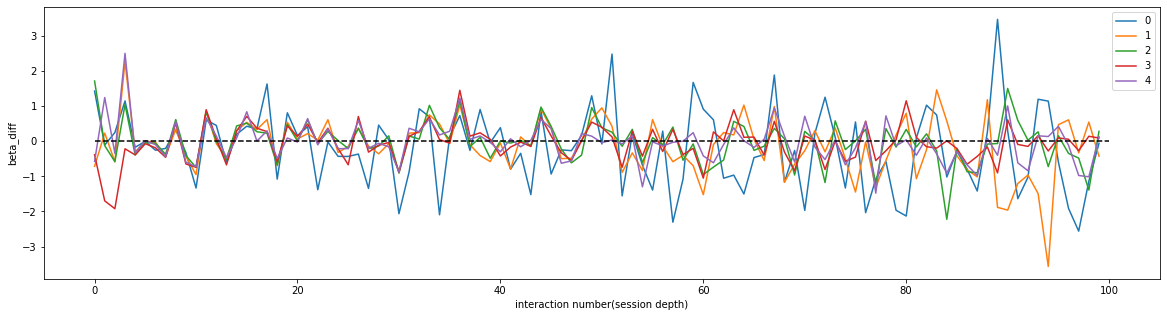

In [142]:
# 对beta进行分析：
# beta_diff 在不同时刻的变化plot: win=0
# 不对alpha和gamma范围进行限制，不做预训练
plt.figure(figsize=(20,diff_level))
ax = plt.subplot()
plots = []
Mean = []
for i in range(0,diff_level):
    #plots.append(ax.plot(beta[feature_num-3+i,:100].cumsum()/np.arange(1,101)))
    plots.append(ax.plot(beta[feature_num-3+i,:100]))
    Mean.append(beta[feature_num-3+i,:100].mean())


#labels = ["[0.6,1)","[-0.2,0.2)","(-1,-0.6]"]
labels = np.arange(0,diff_level)
plt.legend(plots,labels=labels)
ax.plot([0,100],[0,0],"--k")
ax.set_xlabel("interaction number(session depth)")
ax.set_ylabel("beta_diff")
Mean

/work/lijiayu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  from ipykernel import kernelapp as app


[-0.12189187, -0.028407639, 0.1672031, 0.1304059, 0.018258877]

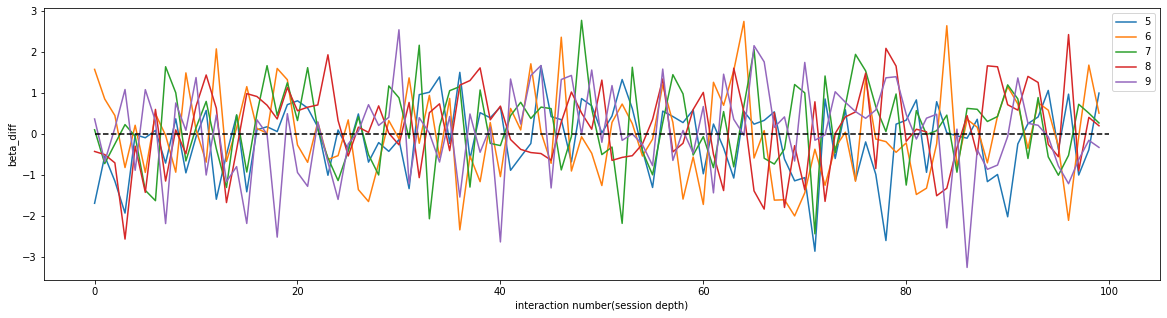

In [147]:
# 对beta进行分析：
# beta_diff 在不同时刻的变化plot: win=1
# 不对alpha和gamma范围进行限制
plt.figure(figsize=(20,diff_level))
ax = plt.subplot()
plots = []
Mean = []
for i in range(0,diff_level):
    #plots.append(ax.plot(beta[feature_num-3+diff_level+i,:100].cumsum()/np.arange(1,101)))
    plots.append(ax.plot(beta[feature_num-3+diff_level+i,:100]))
    Mean.append(beta[feature_num-3+diff_level+i,:100].mean())

#labels = ["[0.6,1)","[-0.2,0.2)","(-1,-0.6]"]
labels = np.arange(diff_level,2*diff_level)
plt.legend(plots,labels=labels)
ax.plot([0,100],[0,0],"--k")
ax.set_xlabel("interaction number(session depth)")
ax.set_ylabel("beta_diff")
Mean

In [59]:
beta[-5:,:].argmin(axis=0)

array([0, 0, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 2, 1, 1, 1, 3, 0, 1, 0, 3, 4,
       1, 3, 2, 4, 3, 2, 4, 2, 1, 3, 4, 3, 2, 0, 4, 0, 2, 2, 4, 3, 3, 3,
       3, 3, 1, 1, 0, 4, 3, 3, 3, 4, 4, 0, 3, 2, 1, 3, 3, 3, 3, 2, 3, 3,
       3, 0, 4, 2, 4, 2, 3, 1, 1, 3, 3, 2, 3, 2, 4, 1, 2, 3, 2, 2, 0, 3,
       3, 2, 3, 2, 2, 2, 1, 2, 4, 3, 3, 2, 2, 2, 4, 2, 2, 3, 3, 2, 2, 3,
       2, 2, 3, 3, 2, 2, 3, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 2, 3, 2,
       2, 2, 2, 2, 3, 2, 3, 2, 3, 3, 2, 2, 2, 3, 2, 3, 2, 2, 1, 3, 3, 3,
       2, 2, 4, 2, 4, 1])

------
## 计算MSE loss

In [48]:
surv_df.shape

(160, 12411)

In [49]:
def h(t,x,uid):
    g_x = model.net.predict(x,uid)
    h_t = baseline_hazards.iloc[t]*np.exp(g_x)
    return h_t

In [50]:
def E(X,uid):
    # x: length*feature*length
    h_list = np.zeros(max_length)
    for t in range(max_length):
        h_list[t] = h(t,X[t,:,:],uid)
    S_list = [np.exp(-np.cumsum(h_list[:t])) for t in range(max_length)]
    E_k = [t*h_list[t]*S_list[t] for t in range(max_length)]
    
    return sum(E_k)

In [ ]:
for x,y in zip(x_train,y_train):
    (E(x,uid)-y)**2

-----
## Example in documentation

### Dataset

In [76]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

### Feature transforms

In [77]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [373]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [374]:
x_train

array([[-1.1060234 ,  3.3136647 , -0.3857527 , ...,  0.        ,
         0.        ,  1.        ],
       [-0.35232577,  0.54783857,  1.2666992 , ...,  1.        ,
         0.        ,  1.        ],
       [-0.7036777 , -0.53397244, -0.67163885, ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [-0.08655925, -0.90103173,  2.6131732 , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.71274495, -0.8366332 ,  0.6886321 , ...,  0.        ,
         0.        ,  1.        ],
       [-0.5830995 , -0.7607197 , -0.7744629 , ...,  1.        ,
         0.        ,  0.        ]], dtype=float32)

In [78]:
labtrans = CoxTime.label_transform()
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))
durations_test, events_test = get_target(df_test)
val = tt.tuplefy(x_val, y_val)

/work/lijiayu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass copy=True, with_mean=True, with_std=True as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [79]:
y_train[0].shape,y_train[1].shape

((1218,), (1218,))

In [7]:
val.shapes()

((305, 9), ((305,), (305,)))

In [376]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
batch_norm = True
dropout = 0.1
net = MLPVanillaCoxTime(in_features, num_nodes, batch_norm, dropout)

In [379]:
help(net.forward)

Help on method forward in module pycox.models.cox_time:

forward(input, time) method of pycox.models.cox_time.MLPVanillaCoxTime instance
    Defines the computation performed at every call.
    
    Should be overridden by all subclasses.
    
    .. note::
        Although the recipe for forward pass needs to be defined within
        this function, one should call the :class:`Module` instance afterwards
        instead of this since the former takes care of running the
        registered hooks while the latter silently ignores them.



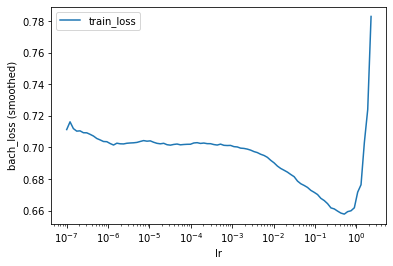

In [161]:
model = CoxTime(net, tt.optim.Adam, labtrans=labtrans)
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=2)
_ = lrfinder.plot()

In [162]:
lrfinder.get_best_lr()

0.050941380148164093

In [163]:
model.optimizer.set_lr(0.01)
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [164]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val.repeat(10).cat())


0:	[0s / 0s],		train_loss: 0.6869,	val_loss: 0.6731
1:	[0s / 0s],		train_loss: 0.6478,	val_loss: 0.6557
2:	[0s / 0s],		train_loss: 0.6318,	val_loss: 0.6366
3:	[0s / 0s],		train_loss: 0.6262,	val_loss: 0.6301
4:	[0s / 0s],		train_loss: 0.5963,	val_loss: 0.6129
5:	[0s / 0s],		train_loss: 0.5942,	val_loss: 0.6120
6:	[0s / 0s],		train_loss: 0.5982,	val_loss: 0.6115
7:	[0s / 1s],		train_loss: 0.5936,	val_loss: 0.6001
8:	[0s / 1s],		train_loss: 0.5762,	val_loss: 0.5858
9:	[0s / 1s],		train_loss: 0.5849,	val_loss: 0.6056
10:	[0s / 1s],		train_loss: 0.6085,	val_loss: 0.6052
11:	[0s / 1s],		train_loss: 0.5891,	val_loss: 0.6104
12:	[0s / 1s],		train_loss: 0.5860,	val_loss: 0.6095
13:	[0s / 1s],		train_loss: 0.5837,	val_loss: 0.6077
14:	[0s / 1s],		train_loss: 0.5901,	val_loss: 0.6071
15:	[0s / 1s],		train_loss: 0.5896,	val_loss: 0.6090
16:	[0s / 1s],		train_loss: 0.5818,	val_loss: 0.5916
17:	[0s / 1s],		train_loss: 0.5661,	val_loss: 0.5925
18:	[0s / 2s],		train_loss: 0.5657,	val_loss: 0.6010
CPU

----

## 生成random的测试数据

In [34]:
train_sample = 1000
x_input = torch.zeros((train_sample,20,100))# 10000 samples * 20 features * 100 length
for i in range(train_sample):
    a = torch.randint(100,[1]).item()
    x_input[i,:,a] = torch.randn(20)
uid = torch.zeros((train_sample,30)) # 10000 samples, 30 users
for i in range(train_sample):
    a = torch.randint(30,[1]).item()
    uid[i,a] = 1

In [35]:
x_train_rand = (x_input, uid)
#y_train_rand = (torch.randint(100,[train_sample]), torch.ones((train_sample)))
#y_train_rand = (torch.ones((10000))*80,torch.ones((10000)))
y_train_rand = (np.random.randint(100,size=train_sample),np.ones(train_sample))

In [36]:
uid.shape

torch.Size([1000, 30])

In [6]:
val_sample = 100
x_input_val =  torch.zeros((val_sample,20,100))# 1000 samples * 20 features * 100 length
for i in range(val_sample):
    a = torch.randint(100,[1]).item()
    x_input_val[i,:,a] = torch.randn(20)
uid_val = torch.zeros((val_sample,30))
for i in range(val_sample):
    a = torch.randint(30,[1]).item()
    uid_val[i,a] = 1

In [7]:
x_val_rand = (x_input_val, uid_val)
#y_val_rand = (torch.ones((1000))*80, torch.ones((1000)))
#y_val_rand = (torch.randint(100,[val_sample]), torch.ones((val_sample)))
y_val_rand = (np.random.randint(100,size=val_sample),np.ones(val_sample))

In [8]:
x_input.shape,uid.shape

(torch.Size([1000, 20, 100]), torch.Size([1000, 30]))

## 已废弃的模型定义

In [3]:
# class DiffNet(nn.Module):
#     def __init__(self, feature_num, user_num, length, skill_dim=-1, challenge_dim=-2, diff_level=5,device="cpu"):
#         super().__init__()
#         beta = torch.randn((feature_num-2+diff_level, length))
#         self.beta = nn.Parameter(beta)
#         alpha = torch.rand((user_num,1))
#         self.alpha = nn.Parameter(alpha)
#         self.skill_dim = skill_dim
#         self.challenge_dim = challenge_dim
#         self.diff_level = diff_level
#         self.feature_num = feature_num
#         self.user_num = user_num
#         self.length = length
#         self.device = device
    
#     def forward(self, x_input, uid, all_zero=0):
#         u_alpha = torch.mm(uid, torch.clamp(self.alpha.abs(),0,1)).sum(dim=1) # uid: batch_size*user_num, u_alpha: batch_size*1
#         # x_input: batch_size * feature_num * length
#         x_diff = (x_input[:,self.challenge_dim,:]-torch.mul(x_input[:,self.skill_dim,:],u_alpha.unsqueeze(1))) # x_diff: batch_size*length
        
#         level_diff = self.calculate_diff(x_diff)
        
#         feature_idx = [i for i in range(feature_num) if 
#                        i not in [self.skill_dim,self.challenge_dim] and i-feature_num not in [self.skill_dim,self.challenge_dim]]
#         x_input_diff = torch.cat((x_input[:,feature_idx,:],level_diff),dim=1)
        
#         y = x_input_diff.mul(self.beta)  # y: batch_size * feature_num * length
#         return torch.sum(y,(1,2)) # y: batch_size *1
    
#     def predict(self, x_input, uid, all_zero=0):
#         return self.forward(x_input, uid,0)
    
#     def one_hot(self, label):
#         batch_size = label.shape[0]
#         label = label.resize_(batch_size, 1)
#         if self.device=='cpu':
#             m_zeros = torch.zeros(batch_size, self.diff_level+1)
#         else:
#             m_zeros = torch.zeros(batch_size, self.diff_level+1).cuda()
#         onehot = m_zeros.scatter_(1, label, 1)[:,:-1]  # (dim,index,value)

#         return onehot  # Tensor -> Numpy
    
#     def calculate_diff(self, x):
#         # x: batch_size*length
#         #x_level = self.one_hot((x_diff.max(dim=1)[0]*self.diff_level).floor().long())# batch_size * diff_level
        
#         #level_diff = torch.mul((x_diff*self.diff_level).frac().unsqueeze(1).repeat(1,self.diff_level,1),x_level.unsqueeze(2).repeat(1,1,self.length))# batch_size * diff_level * length
#         #level_diff = torch.mul(x_diff.unsqueeze(1).repeat(1,self.diff_level,1),x_level.unsqueeze(2).repeat(1,1,self.length))# batch_size * diff_level * length
        
#         x_level = self.one_hot(((x.sum(dim=1)+1)/2*self.diff_level).floor().long()) # x_level: batch_size * diff_level
#         level_diff = torch.mul((x!=0).float().unsqueeze(1).repeat(1,self.diff_level,1),x_level.unsqueeze(2).repeat(1,1,self.length))# batch_size * diff_level * length
        
#         return level_diff
#         # return: batch_size* diff_level * length

In [77]:
# # difficulty 不分情况
# class DiffNet(nn.Module):
#     def __init__(self, feature_num, user_num, length, skill_dim=-1, challenge_dim=-2, diff_level=5,device="cpu"):
#         super().__init__()
#         beta = torch.randn((feature_num-2+diff_level, length))
#         self.beta = nn.Parameter(beta)
#         alpha = torch.rand((user_num,1))
#         self.alpha = nn.Parameter(alpha)
#         self.skill_dim = skill_dim
#         self.challenge_dim = challenge_dim
#         self.diff_level = diff_level
#         self.feature_num = feature_num
#         self.user_num = user_num
#         self.length = length
#         self.device = device
    
#     def forward(self, x_input, uid, t):
#         # x_input: batch_size * feature_num * length
#         # uid: batch_size * user_num
#         u_alpha = torch.mm(uid, torch.clamp(self.alpha.abs(),0,1)).sum(dim=1) # u_alpha: batch_size*1
#         x_diff = (x_input[:,self.challenge_dim,:]-torch.mul(x_input[:,self.skill_dim,:],u_alpha.unsqueeze(1))) # x_diff: batch_size*length
        
#         level_diff = self.calculate_diff(x_diff)
        
#         feature_idx = [i for i in range(feature_num) if 
#                        i not in [self.skill_dim,self.challenge_dim] and i-feature_num not in [self.skill_dim,self.challenge_dim]]
#         x_input_diff = torch.cat((x_input[:,feature_idx,:],level_diff),dim=1) # batch_size*feature*length
        
#         y = self.time_mul(x_input_diff,t)  # y: batch_size * 1
#         return y # y: batch_size *1
    
#     def time_mul(self, x_input, t):
#         # x_input: batch_size * feature * length
#         # t: batch_size * 1
#         batch_size = x_input.shape[0]
#         #t = t.long().detach().cpu().numpy()-1

#         #y = []
#         #for i in range(batch_size):
#         #    y.append((x_input[i,:,t[i]]*self.beta[:,t[i]]).sum())
        
#         x_beta = (x_input*self.beta).sum(dim=1) # batch_size*length
#         #y = x_beta[np.arange(batch_size),t.long()-1]
#         y = torch.gather(x_beta,dim=1,index=t.long()-1)#.unsqueeze(1)
        
#         #return torch.stack(y)
#         return y
    
#     def predict(self, x_input, uid, t):
#         return self.forward(x_input, uid, t)
    
#     def one_hot(self, label):
#         batch_size = label.shape[0]
#         length = label.shape[1]
#         label = label.resize_(batch_size, 1, length)
#         if self.device=='cpu':
#             m_zeros = torch.zeros(batch_size,  self.diff_level+1, length)
#         else:
#             m_zeros = torch.zeros(batch_size,  self.diff_level+1, length).cuda()
#         onehot = m_zeros.scatter_(1, label, 1)[:,:-1]  # (dim,index,value)
        
#         return onehot  # Tensor -> Numpy
    
#     def calculate_diff(self, x):
#         # x: batch_size*length
        
#         x_level = self.one_hot(((x+1)/2*self.diff_level).floor().long()) # x_level: batch_size * diff_level * length
        
#         return x_level  #batch_size* diff_level * length